In [47]:
include("../code/julia/ha-trade.jl")
include("../code/julia/ha-trade-welfare.jl")

using MINPACK
using Plots
using CSV
using DataFrames

In [48]:
γ = 1.5 # curvatuve on CRRA utility function
σϵ = 0.25 # logit dispersion parameter
Ncntry = 2 # number of countries

# this setups up parameters on the household side
hh_prm = household_params(Ncntry = Ncntry, Na = 100, β = 0.92, γ = γ, ϕ = 0.5, amax = 8.0, σϵ = σϵ, ψslope = 0.1);

#ψslope controls how residual demand varies with income state...

In [49]:
# here are some simpe country parametrers
TFP = [1.0; 1.0]

τ = [0.0; 0.0]

L = [1.0; 1.0]

d_ij = 1.745

d = [1.0 d_ij; d_ij 1.0]

# this sets up the country specific paramters
cntry_prm = country_params(Ncntry = Ncntry, L = L, d = d, TFP = TFP);

In [50]:
f(x) = world_equillibrium_FG(exp.(x), hh_prm, cntry_prm)
# this world... function is used to construct zero conditions for
# the finacial globalization case

function f!(fvec, x)

    fvec .= f(x)

end


xguess = [1.0; 1.02]

n = length(xguess)
diag_adjust = n - 1

sol = fsolve(f!, log.(xguess), show_trace = true, method = :hybr;
      ml=diag_adjust, mu=diag_adjust,
      diag=ones(n),
      mode= 1,
      tol=1e-10,
       )

# This solver works very well in general. Spencer Lyon converted old-school minpack
# routines in C into julia

print(sol)

wage = [exp.(sol.x[1]); 1.0]
R = exp.(sol.x[2])

Iter     f(x) inf-norm    Step 2-norm      Step time
------   --------------   --------------   --------------
     1     1.779833e-01     0.000000e+00         2.556000
     2     1.834803e-02     3.346991e-05         0.368000
     3     2.340031e-03     7.242688e-07         0.099000
     4     3.130449e-05     1.540005e-08         0.112000
     5     3.220510e-09     2.922568e-12         0.124000
     6     2.211893e-10     1.648864e-20         0.154000
     7     1.137701e-11     1.506451e-22         0.134000
     8     1.110223e-15     3.598482e-25         0.105000
Results of Nonlinear Solver Algorithm
 * Algorithm: Modified Powell
 * Starting Point: [0.0, 0.01980262729617973]
 * Zero: [-1.980166960742154e-9, 0.013318785492015015]
 * Inf-norm of residuals: 0.000000
 * Convergence: true
 * Message: algorithm estimates that the relative error between x and the solution is at most tol
 * Total time: 3.673000 seconds
 * Function Calls: 8
 * Jacobian Calls (df/dx): 1

1.0134078756001383

In [51]:
Rsol = [R; R]

Y, tradeflows, A_demand, Gbudget, tradeshare, hh, dist = world_equillibrium(Rsol, wage, τ, hh_prm, cntry_prm, tol_vfi = 1e-10);


In [52]:
tradeshare

2×2 Matrix{Float64}:
 0.907683   0.0923174
 0.0923174  0.907683

In [53]:
hh[1].πprob[:,:,2]
# guys in country one, a X z, probability of buying from 2

100×10 Matrix{Float64}:
 0.0123683  0.0263934  0.0278123  …  0.085091   0.101646  0.0974459
 0.0229131  0.0290891  0.0384738     0.0863241  0.104807  0.0979406
 0.0318883  0.0360846  0.0487218     0.0874369  0.107008  0.0984254
 0.0357077  0.0385349  0.0528117     0.0884365  0.108295  0.0989024
 0.0431867  0.0413005  0.058418      0.089367   0.109306  0.0993711
 0.0463467  0.0453306  0.0621392  …  0.0902549  0.110198  0.0998321
 0.0497325  0.0479265  0.0651542     0.0911469  0.111038  0.100295
 0.054067   0.0504785  0.0687932     0.0920067  0.111818  0.100734
 0.0573708  0.0530139  0.0718904     0.0927955  0.112531  0.101164
 0.0603271  0.0555697  0.07426       0.0935734  0.113184  0.101587
 0.0632998  0.0578055  0.0764887  …  0.0943328  0.113805  0.102004
 0.0663396  0.0600312  0.0788845     0.0950693  0.114401  0.102414
 0.0689177  0.0622093  0.081331      0.0957857  0.114992  0.10282
 ⋮                                ⋱                       
 0.172909   0.149711   0.163565      0.13

In [54]:
cntry = 1 # this is the country I'll look at

# the next several functions are what is done to make
# the country specific, household parameter vector.

p = make_p(wage, TFP, d[cntry, :], cntry_prm.tariff[cntry, :] )
# prices from the perspective of those in that country

ψ = make_ψ(cntry, hh_prm)
# this is the quality matrix

agrid = make_agrid(hh_prm, TFP[cntry])
# this creates teh asset grid so it's alwasy a fraction of home labor income

foo_hh_prm = household_params(hh_prm, agrid = agrid, 
                TFP = TFP[cntry], L = L[cntry], σϵ = σϵ*(TFP[cntry]^(1.0 - γ)), ψ = ψ)


hh = solve_household_problem(R, wage[cntry], p, τ[cntry], foo_hh_prm, tol = 1e-10);
# solve hh problem at those prices

dist = make_stationary_distribution(hh, foo_hh_prm);
# find stationary distribution

In [55]:
θ = make_θ(cntry, R, wage[cntry], p, τ[cntry], foo_hh_prm; points = 3, order = 1)
# makes the micro elasticities for country, cntry, 

ω = make_ω(hh, dist, L[cntry], p, foo_hh_prm)
# makes the expenditure weights

agθ = aggregate_θ(θ, ω, cntry, foo_hh_prm)
# construct the aggregate elasticity. The interesting element here is 
# agθ[cntry]

2-element Vector{Float64}:
  1.0
 -4.276188083313216

In [56]:
θ.θπ[:,:,2]

100×10 Matrix{Float64}:
 -9.92771  -7.59396  -7.75733  -6.06626  …  -3.89379  -3.60655  -3.24132
 -8.57619  -7.40198  -7.00841  -5.95158     -3.84593  -3.50205  -3.22776
 -7.52457  -6.81225  -6.40377  -5.6867      -3.83579  -3.40827  -3.21381
 -7.32797  -6.75079  -6.02647  -5.65116     -3.80278  -3.33002  -3.20023
 -6.75316  -6.57046  -5.88911  -5.49517     -3.76661  -3.31671  -3.18687
 -6.69131  -6.28388  -5.62589  -5.31957  …  -3.738    -3.28566  -3.17318
 -6.50416  -6.24832  -5.5081   -5.24718     -3.71034  -3.25973  -3.16107
 -6.23371  -6.09809  -5.42944  -5.22556     -3.70499  -3.23624  -3.15942
 -6.18324  -5.96719  -5.25519  -5.13047     -3.67909  -3.23231  -3.14827
 -6.03263  -5.93205  -5.18115  -5.02527     -3.65535  -3.21415  -3.13756
 -5.89893  -5.79634  -5.15724  -4.958    …  -3.63166  -3.19612  -3.12682
 -5.76151  -5.68438  -5.06162  -4.94452     -3.61044  -3.18117  -3.11627
 -5.73322  -5.59147  -4.95654  -4.87949     -3.58967  -3.16647  -3.1057
  ⋮                         

In [60]:
fooX = make_Xsection(R, wage[cntry], p, hh, dist, cntry, foo_hh_prm; Nsims = 100000)

hhXsection([0.445225383126952, 0.445225383126952, 0.445225383126952, 0.7031196097554934, 0.445225383126952, 1.1060902644956714, 0.7031196097554934, 0.445225383126952, 0.7031196097554934, 0.7031196097554934  …  0.7003921593856945, 0.7003921593856945, 1.1060902644956714, 1.1060902644956714, 1.740010741042407, 1.1017996626420568, 1.1017996626420568, 1.740010741042407, 1.740010741042407, 1.1017996626420568], [3.106060606060606, 2.2474747474747474, 1.6464646464646464, 1.1313131313131313, 0.8737373737373737, 0.5303030303030303, 0.5303030303030303, 0.4444444444444444, 0.10101010101010101, 0.015151515151515152  …  -0.41414141414141414, -0.5, -0.5, -0.3282828282828283, -0.15656565656565657, 0.2727272727272727, 0.015151515151515152, -0.24242424242424243, 0.18686868686868688, 0.5303030303030303], [3.592931663400109, 2.722833992430293, 2.1137656227514223, 1.8496012467980742, 1.3306777188785879, 1.643503531859381, 1.240532877119203, 0.8956288833936801, 0.8054840416342952, 0.7184742745373136  …  0.2

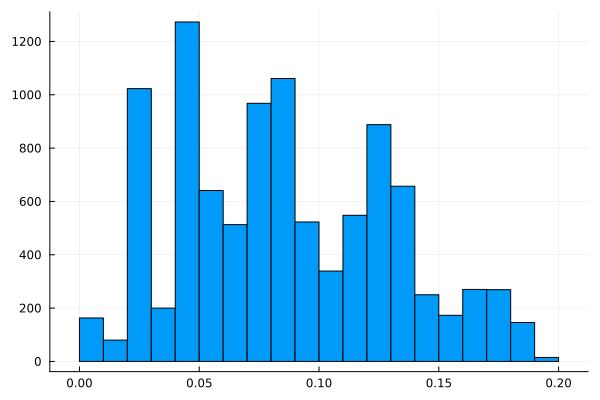

In [41]:
histogram((1.0 .-fooX.homeshare), label = false)

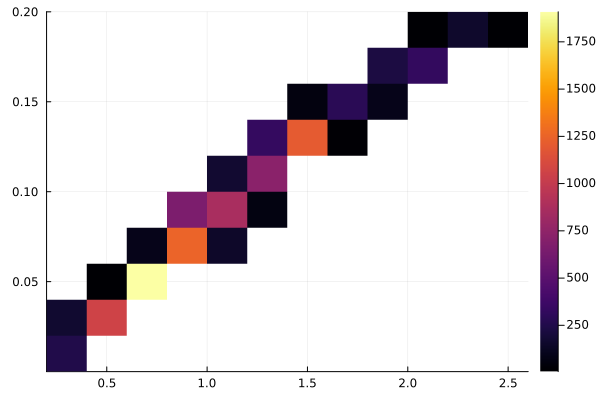

In [46]:
histogram2d(fooX.pc, (1.0 .-fooX.homeshare))

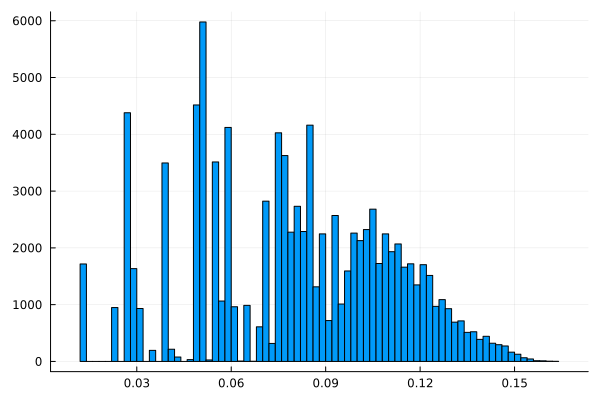

In [61]:
histogram((1.0 .-fooX.homeshare), label = false)

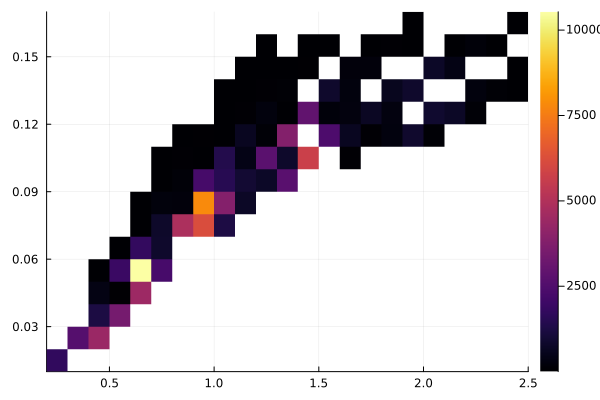

In [62]:
histogram2d(fooX.pc, (1.0 .-fooX.homeshare))

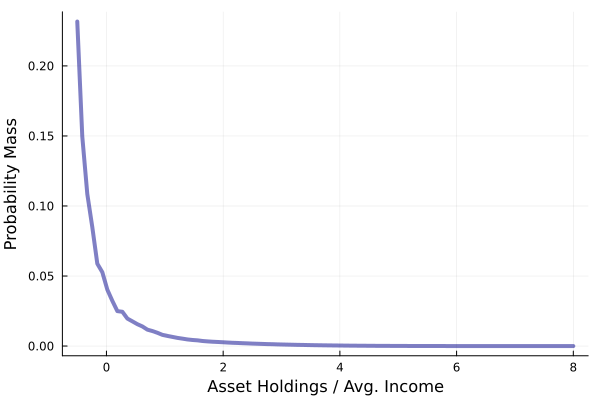

In [21]:
adist = get_distribution(dist.state_index, dist.λ);

plot(hh_prm.agrid , adist, alpha = 0.5, lw = 4,
    color = "dark blue", ylabel = "Probability Mass", 
    xlabel = "Asset Holdings / Avg. Income", label = false)